## **Fraud Detection in Python**

**Course Description**

A typical organization loses an estimated 5% of its yearly revenue to fraud. In this course, learn to fight fraud by using data. Apply supervised learning algorithms to detect fraudulent behavior based upon past fraud, and use unsupervised learning methods to discover new types of fraud activities. 

Fraudulent transactions are rare compared to the norm.  As such, learn to properly classify imbalanced datasets.

The course provides technical and theoretical insights and demonstrates how to implement fraud detection models. Finally, get tips and advice from real-life experience to help prevent common mistakes in fraud analytics.

**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

**Pandas Configuration Options**

In [3]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

**Data File Objects**

In [4]:
data = Path.cwd() / 'data'

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

# Introduction and preparing the data

Learn about the typical challenges associated with fraud detection. Learn how to resample data in a smart way, and tackle problems with imbalanced data.

## Introduction to fraud detection

* Types:
    * Insurance
    * Credit card
    * Identity theft
    * Money laundering
    * Tax evasion
    * Healthcare
    * Product warranty
* e-commerce businesses must continuously assess the legitimacy of client transactions
* Detecting fraud is challenging:
    * Uncommon; < 0.01% of transactions
    * Attempts are made to conceal fraud
    * Behavior evolves
    * Fraudulent activities perpetrated by networks - organized crime
* Fraud detection requires training an algorithm to identify concealed observations from any normal observations
* Fraud analytics teams:
    * Often use rules based systems, based on manually set thresholds and experience
    * Check the news
    * Receive external lists of fraudulent accounts and names
        * suspicious names or track an external hit list from police to reference check against the client base
    * Sometimes use machine learning algorithms to detect fraud or suspicious behavior
        * Existing sources can be used as inputs into the ML model
        * Verify the veracity of rules based labels

### Checking the fraud to non-fraud ratio

In this, I will work on `creditcard_sampledata.csv`, a dataset containing credit card transactions data. Fraud occurrences are fortunately an **extreme minority** in these transactions.

However, Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as **class imbalance**, and it's one of the main challenges of fraud detection.

Let's explore this dataset, and observe this class imbalance problem.

**To Do**

* `import pandas as pd`, read the credit card data in and assign it to `df`.
* Use `.info()` to print information about `df`.
* Use `.value_counts()` to get the count of fraudulent and non-fraudulent transactions in the `'Class'` column. Assign the result to `occ`.
* Get the ratio of fraudulent transactions over the total number of transactions in the dataset.

In [5]:
df = pd.read_csv(cc3_file)

#### Explore the features available in the dataframe

In [6]:
# df.info()

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [8]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    5000
1      50
Name: Class, dtype: int64

In [9]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


**The ratio of fraudulent transactions is very low. This is a case of class imbalance problem, and I'm going to learn how to deal with this in the next exercises.**

### Data visualization

From the previous exercise we know that the ratio of fraud to non-fraud observations is very low. I can do something about that, for example by **re-sampling** our data.

In this exercise, I'll look at the data and **visualize the fraud to non-fraud ratio**. It is always a good starting point in the fraud analysis, to look at the data first, before I make any changes to it.

Moreover, when talking to the colleagues, a picture often makes it very clear that we're dealing with heavily imbalanced data. Let's create a plot to visualize the ratio fraud to non-fraud data points on the dataset `df`.

Using the function `prep_data()` - created below - as well as `matplotlib.pyplot as plt`.

**To Do**

* Define the `plot_data(X, y)` function, that will nicely plot the given feature set `X` with labels `y` in a scatter plot.
* Use the function `prep_data()` on the dataset `df` to create feature set `X` and labels `y`.
* Run the function `plot_data()` on the newly obtained `X` and `y` to visualize the results.

#### def prep_data

In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

#### def plot_data

In [11]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [12]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

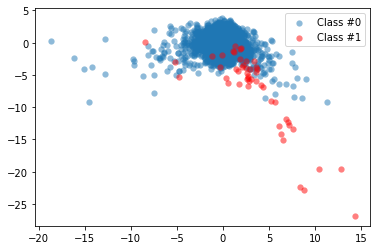

In [13]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

**By visualizing the data, I can immediately see how our fraud cases are scattered over our data, and how few cases we have. A picture often makes the imbalance problem clear. Next exercises we'll try to visually explore how to improve our fraud to non-fraud balance.**

#### Reproduced using the DataFrame

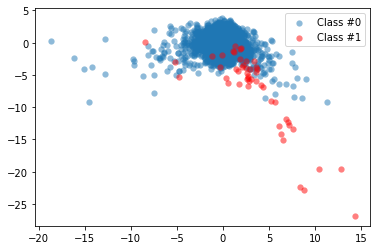

In [14]:
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

## Increase successful detections with data resampling

* resampling can help model performance in cases of imbalanced data sets

#### Undersampling

* ![undersampling](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/undersampling.JPG)
* Undersampling the majority class (non-fraud cases)
    * Straightforward method to adjust imbalanced data
    * Take random draws from the non-fraud observations, to match the occurences of fraud observations (as shown in the picture)

#### Oversampling

* ![oversampling](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/oversampling.JPG)
* Oversampling the minority class (fraud cases)
    * Take random draws from the fraud cases and copy those observations to increase the amount of fraud samples
* Both methods lead to having a balance between fraud and non-fraud cases
* Drawbacks
    * with random undersampling, a lot of information is thrown away
    * with oversampling, the model will be trained on a lot of duplicates

#### Implement resampling methods using Python imblean module

* compatible with scikit-learn

```python
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled =  method.fit_sample(X, y)

compare_plots(X_resampled, y_resampled, X, y)
```

![oversampling plot](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/oversampling_plot.JPG)
* The darker blue points reflect there are more identical data

#### SMOTE

* ![smote](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/smote.JPG)
* Synthetic minority Oversampling Technique (SMOTE)
    * [Resampling strategies for Imbalanced Data Sets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
    * Another way of adjusting the imbalance by oversampling minority observations
    * SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases
        * avoids duplicating observations

#### Determining the best resampling method is situational

* Random Undersampling (RUS):
    * If there is a lot of data and many minority cases, then undersampling may be computationally more convenient
        * In most cases, throwing away data is not desirable
* Random Oversampling (ROS):
    * Straightforward
    * Training the model on many duplicates
* SMOTE:
    * more sophisticated
    * realistic data set
    * training on synthetic data
    * only works well if the minority case features are similar
        * **if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases**

#### When to use resmapling methods

* Use resampling methods on the training set, not on the test set
* The goal is to produce a better model by providing balanced data
    * The goal is not to predict the synthetic samples
* Test data should be free of duplicates and synthetic data
* Only test the model on real data
    * First, spit the data into train and test sets
    
```python
# Define resampling method and split into train and test
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Get model performance metrics
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
```

### Applying Synthetic Minority Oversampling Technique (SMOTE)

In this exercise, I'm going to re-balance our data using the **Synthetic Minority Over-sampling Technique** (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but **creates new, synthetic, samples** that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so let's apply SMOTE to our credit card data. The dataset `df` is available and the packages I need for SMOTE are imported. In the following exercise, I'll visualize the result and compare it to the original data, such that I can see the effect of applying SMOTE very clearly.

**To Do**

* Use the `prep_data` function on `df` to create features `X` and labels `y`.
* Define the resampling method as SMOTE of the regular kind, under the variable `method`.
* Use `.fit_sample()` on the original `X` and `y` to obtain newly resampled data.
* Plot the resampled data using the `plot_data()` function.

In [15]:
# Run the prep_data function
X, y = prep_data(df)

In [16]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


In [17]:
# Define the resampling method
method = SMOTE()

In [19]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

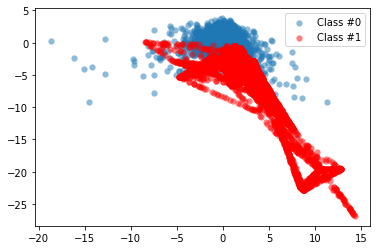

In [20]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

**The minority class is now much more prominently visible in our data. To see the results of SMOTE even better, we'll compare it to the original data in the next exercise.**

### Compare SMOTE to original data

In the last exercise, I saw that using SMOTE suddenly gives us more observations of the minority class. Let's compare those results to our original data, to get a good feeling for what has actually happened. Let's have a look at the value counts again of our old and new data, and let's plot the two scatter plots of the data side by side. I'll use the function compare_plot() for that that, which takes the following arguments: `X`, `y`, `X_resampled`, `y_resampled`, `method=''`. The function plots the original data in a scatter plot, along with the resampled side by side.

**To Do**

* Print the value counts of our original labels, `y`. Be mindful that `y` is currently a Numpy array, so in order to use value counts, we'll assign `y` back as a pandas Series object.
* Repeat the step and print the value counts on `y_resampled`. This shows how the balance between the two classes has changed with SMOTE.
* Use the `compare_plot()` function called on our original data as well our resampled data to see the scatterplots side by side.

In [21]:
pd.value_counts(pd.Series(y))

0    5000
1      50
dtype: int64

In [22]:
pd.value_counts(pd.Series(y_resampled))

1    5000
0    5000
dtype: int64

#### def compare_plot

In [23]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

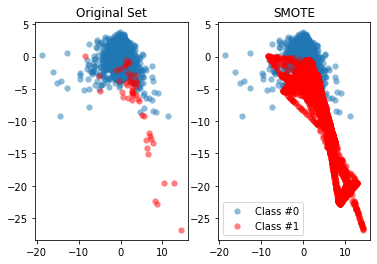

In [24]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

**It should by now be clear that SMOTE has balanced our data completely, and that the minority class is now equal in size to the majority class. Visualizing the data shows the effect on the data very clearly. The next exercise will demonstrate multiple ways to implement SMOTE and that each method will have a slightly different effect.**

## Fraud detection algorithms in action

#### Rules Based Systems

* ![rules based](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/rules_based.JPG)
* Might block transactions from risky zip codes
* Block transactions from cards used too frequently (e.g. last 30 minutes)
* Can catch fraud, but also generates false alarms (false positive)
* Limitations:
    * Fixed threshold per rule and it's difficult to determine the threshold; they don't adapt over time
    * Limited to yes / no outcomes, whereas ML yields a probability
        * probability allows for fine-tuning the outcomes (i.e. rate of occurences of false positives and false negatives)
    * Fails to capture interaction between features
        * Ex. Size of the transaction only matters in combination to the frequency

#### ML Based Systems

* Adapt to the data, thus can change over time
* Uses all the data combined, rather than a threshold per feature
* Produces a probability, rather than a binary score
* Typically have better performance and can be combined with rules

In [25]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# Step 2: Define which model to use
model = LinearRegression()

In [27]:
# Step 3: Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [28]:
# Step 4: Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [29]:
# Step 5: Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.7106146994937109

### Exploring the traditional method of fraud detection

In this exercise I'm going to try finding fraud cases in our credit card dataset the *"old way"*. First I'll define threshold values using common statistics, to split fraud and non-fraud. Then, use those thresholds on the features to detect fraud. This is common practice within fraud analytics teams.

Statistical thresholds are often determined by looking at the **mean** values of observations. Let's start this exercise by checking whether feature **means differ between fraud and non-fraud cases**. Then, I'll use that information to create common sense thresholds. Finally, I'll check how well this performs in fraud detection.

`pandas` has already been imported as `pd`.

**To Do**

* Use `groupby()` to group `df` on `Class` and obtain the mean of the features.
* Create the condition `V1` smaller than -3, and `V3` smaller than -5 as a condition to flag fraud cases.
* As a measure of performance, use the `crosstab` function from `pandas` to compare our flagged fraud cases to actual fraud cases.

In [30]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [31]:
df.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,-0.004511,0.017434,0.004204,0.006542,-0.026640,0.001190,0.004481,-0.010892,-0.016554,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,4.020563,-7.032865,-0.104179,-7.100399,-0.120265,-4.658854,-7.589219,-2.650436,0.894255,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [32]:
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [33]:
pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


**With this rule, 22 out of 50 fraud cases are detected, 28 are not detected, and 16 false positives are identified.**

### Using ML classification to catch fraud

In this exercise I'll see what happens when I use a simple machine learning model on our credit card data instead.

Can we beat those results? I predicted *22 out of 50* fraud cases, and had *16 false positives*.

So with that in mind, let's implement a **Logistic Regression** model.

The `X` and `y` variables are available in the workspace.

**To Do**

* Split `X` and `y` into training and test data, keeping 30% of the data for testing.
* Fit the model to the training data.
* Obtain the model predicted labels by running `model.predict` on `X_test`.
* Obtain a classification comparing `y_test` with `predicted`, and use the given confusion matrix to check the results.

In [34]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [36]:
# Obtain model predictions
predicted = model.predict(X_test)

In [37]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


**Do I think these results are better than the rules based model? We are getting far fewer false positives, so that's an improvement. Also, we're catching a higher percentage of fraud cases, so that is also better than before. Do I understand why we have fewer observations to look at in the confusion matrix? Remember we are using only our test data to calculate the model results on. We're comparing the crosstab on the full dataset from the last exercise, with a confusion matrix of only 30% of the total dataset, so that's where that difference comes from. In the next chapter, we'll dive deeper into understanding these model performance metrics. Let's now explore whether we can improve the prediction results even further with resampling methods.**

### Logistic regression with SMOTE

In this exercise, I'm going to take the Logistic Regression model from the previous exercise, and combine that with a **SMOTE resampling method**. We'll show I how to do that efficiently by using a pipeline that combines the resampling method with the model in one go. First, I need to define the pipeline that I'm going to use.

**To Do**

* Import the `Pipeline` module from `imblearn`, this has been done for I.
* Then define what I want to put into the pipeline, assign the `SMOTE` method with `borderline2` to `resampling`, and assign `LogisticRegression()` to the `model`.
* Combine two steps in the `Pipeline()` function. I need to state I want to combine `resampling` with the `model` in the respective place in the argument. I show I how to do this.

In [38]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [39]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

### Pipelining

Now that I have our pipeline defined, aka **combining a logistic regression with a SMOTE method**, let's run it on the data. I can treat the pipeline as if it were a **single machine learning model**. Our data X and y are already defined, and the pipeline is defined in the previous exercise. Are I curious to find out what the model results are? Let's give it a try!

**To Do**

* Split the data 'X'and 'y' into the training and test set. Set aside 30% of the data for a test set, and set the `random_state` to zero.
* Fit the pipeline onto the training data and obtain the predictions by running the `pipeline.predict()` function on our `X_test` dataset.

In [40]:
# Split the data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [41]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [42]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.62      1.00      0.77        10

    accuracy                           1.00      1515
   macro avg       0.81      1.00      0.88      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1499    6]
 [   0   10]]


**As I can see, the SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives, albeit only 7 cases. Remember, resampling doesn't necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. In the next chapters, we'll learn how to also adjust our machine learning models to better detect the minority fraud cases.**

# Fraud detection using labeled data

Learn how to flag fraudulent transactions with supervised learning. Use classifiers, adjust and compare them to find the most efficient fraud detection model.

## Review classification methods

* Classification:
    * The problem of identifying to which class a new observation belongs, on the basis of a training set of data containing observations whose class is known
    * Goal: use known fraud cases to train a model to recognize new cases
    * Classes are sometimes called targets, labels or categories
    * Spam detection in email service providers can be identified as a classification problem
        * Binary classification since there are only 2 classes, spam and not spam
    * Fraud detection is also a binary classification prpoblem
    * Patient diagnosis
    * Classification problems normall have categorical output like yes/no, 1/0 or True/False
    * Variable to predict: $$y\in0,1$$
        * 0: negative calss ('majority' normal cases)
        * 1: positive class ('minority' fraud cases)

#### Logistic Regression

* Logistic Regression is one of the most used ML algorithms in binary classification
* ![logistic regression](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/logistic_regression.JPG)
* Can be adjusted reasonably well to work on imbalanced data...useful for fraud detection

#### Neural Network

* ![neural network](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/neural_network.JPG)
* Can be used as classifiers for fraud detection
* Capable of fitting highly non-linear models to the data
* More complex to implement than other classifiers - not demonstrated here

#### Decision Trees

* ![decision tree](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/decision_tree.JPG)
* Commonly used for fraud detection
* Transparent results, easily interpreted by analysts
* Decision trees are prone to overfit the data

#### Random Forests

* ![random forest](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/random_forest.JPG)
* **Random Forests are a more robust option than a single decision tree**
    * Construct a multitude of decision trees when training the model and outputting the class that is the mode or mean predicted class of the individual trees
    * A random forest consists of a collection of trees on a random subset of features
    * Final predictions are the combined results of those trees
    * Random forests can handle complex data and are not prone to overfit
    * They are interpretable by looking at feature importance, and can be adjusted to work well on highly imbalanced data
    * Their drawback is they're computationally complex
    * Very popular for fraud detection
    * A Random Forest model will be optimized in the exercises
    
**Implementation:**

```python
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted)}')
```

### Natural hit rate

In this exercise, I'll again use credit card transaction data. The features and labels are similar to the data in the previous chapter, and the **data is heavily imbalanced**. We've given I features `X` and labels `y` to work with already, which are both numpy arrays.

First I need to explore how prevalent fraud is in the dataset, to understand what the **"natural accuracy"** is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" I need to "beat" in order to get a **better prediction than by doing nothing**. In the following exercises, I'll create our first random forest classifier for fraud detection. That will serve as the **"baseline"** model that I'm going to try to improve in the upcoming exercises.

**To Do**

* Count the total number of observations by taking the length of the labels `y`.
* Count the non-fraud cases in our data by using list comprehension on `y`; remember `y` is a NumPy array so `.value_counts()` cannot be used in this case.
* Calculate the natural accuracy by dividing the non-fraud cases over the total observations.
* Print the percentage.

In [43]:
df2 = pd.read_csv(cc2_file)
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [44]:
X, y = prep_data(df2)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (7300, 28)
y shape: (7300,)


In [45]:
X[0, :]

array([ 4.28408570e-01,  1.64002800e+00, -1.84885886e+00, -8.70902974e-01,
       -2.04848888e-01, -3.85675453e-01,  3.52792552e-01, -1.09830131e+00,
       -3.34596757e-01, -6.79088729e-01, -3.96709268e-02,  1.37266082e+00,
       -7.32000706e-01, -3.44528134e-01,  1.02475103e+00,  3.80208554e-01,
       -1.08734881e+00,  3.64507163e-01,  5.19236276e-02,  5.07173439e-01,
        1.29256539e+00, -4.67752261e-01,  1.24488683e+00,  6.97706854e-01,
        5.93750372e-02, -3.19964326e-01, -1.74444289e-02,  2.74400000e+01])

In [46]:
df2.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [47]:
# Count the total number of observations from the length of y
total_obs = len(y)
total_obs

7300

In [48]:
# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

7000

In [49]:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

95.89%


**This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now I understand, that if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. Let's see how a random forest does in predicting fraud in our data.**

### Random Forest Classifier - part 1

Let's now create a first **random forest classifier** for fraud detection. Hopefully I can do better than the baseline accuracy I've just calculated, which was roughly **96%**. This model will serve as the **"baseline" model** that I'm going to try to improve in the upcoming exercises. Let's start first with **splitting the data into a test and training set**, and **defining the Random Forest model**. The data available are features `X` and labels `y`.

**To Do**

* Import the random forest classifier from `sklearn`.
* Split the features `X` and labels `y` into a training and test set. Set aside a test set of 30%.
* Assign the random forest classifier to `model` and keep `random_state` at 5. We need to set a random state here in order to be able to compare results across different models.

#### X_train, X_test, y_train, y_test

In [50]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [51]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

### Random Forest Classifier - part 2

Let's see how our Random Forest model performs **without doing anything special to it**. The `model` from the previous exercise is available, and I've already split the data in `X_train, y_train, X_test, y_test`.

**To Do 1/3**

* Fit the earlier defined `model` to our training data and obtain predictions by getting the model predictions on `X_test`.

In [52]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [53]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

**To Do 2/3**

* Obtain and print the accuracy score by comparing the actual labels `y_test` with our predicted labels `predicted`.

In [54]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.991


**To Do 3/3**

What is a benefit of using Random Forests versus Decision Trees?

**Possible Answers**

* ~~Random Forests always have a higher accuracy than Decision Trees.~~
* **Random Forests do not tend to overfit, whereas Decision Trees do.**
* ~~Random Forests are computationally more efficient than Decision Trees.~~
* ~~I can obtain "feature importance" from Random Forest, which makes it more transparent.~~

**Random Forest prevents overfitting most of the time, by creating random subsets of the features and building smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features, so it does not tend to overfit to the entire feature set the way "deep" Decisions Trees do.**

## Perfomance evaluation

* Performance metrics for fraud detection models
* There are other performace metrics that are more informative and reliable than accuracy

#### Accuracy

![accuracy](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/accuracy.JPG)
* Accuracy isn't a reliable performance metric when working with highly imbalanced data (such as fraud detection)
* By doing nothing, aka predicting everything is the majority class (right image), a higher accuracy is obtained than by trying to build a predictive model (left image)

#### Confusion Matrix

![advanced confusion matrix](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/confusion_matrix_advanced.JPG)
![confusion matrix](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/confusion_matrix.JPG)
* [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* False Positives (FP) / False Negatives (FN)
    * FN: predicts the person is not pregnant, but actually is
        * Cases of fraud not caught by the model
    * FP: predicts the person is pregnant, but actually is not
        * Cases of 'false alarm'
    * the business case determines whether FN or FP cases are more important
        * a credit card company might want to catch as much fraud as possible and reduce false negatives, as fraudulent transactions can be incredibly costly
            * a false alarm just means a transaction is blocked
        * an insurance company can't handle many false alarms, as it means getting a team of investigators involved for each positive prediction
        
* True Positives / True Negatives are the cases predicted correctly (e.g. fraud / non-fraud)

#### Precision Recall

* Credit card company wants to optimize for recall
* Insurance company wants to optimize for precision
* Precision:
    * $$Precision=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Positives}$$
    * Fraction of actual fraud cases out of all predicted fraud cases
        * true positives relative to the sum of true positives and false positives
* Recall:
    * $$Recall=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Negatives}$$
    * Fraction of predicted fraud cases out of all actual fraud cases
        * true positives relative to the sum of true positives and false negative
* Precision and recall are typically inversely related
    * As precision increases, recall falls and vice-versa
    * ![precision recall inverse relation](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/precision_recall_inverse.JPG)

#### F-Score

* Weighs both precision and recall into on measure

\begin{align}
F-measure = \frac{2\times{Precision}\times{Recall}}{Precision\times{Recall}} \\ 
\\
= \frac{2\times{TP}}{2\times{TP}+FP+FN}
\end{align}

* is a performance metric that takes into account a balance between Precision and Recall

#### Obtaining performance metrics from sklean

```python
# import the methods
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall = precision_recall_curve(y_test, predicted)
```

#### Receiver Operating Characteristic (ROC) curve to compare algorithms

* Created by plotting the true positive rate against the false positive rate at various threshold settings
* ![roc curve](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/roc_curve.JPG)
* Useful for comparing performance of different algorithms

```python
# Obtain model probabilities
probs = model.predict_proba(X_test)

# Print ROC_AUC score using probabilities
print(metrics.roc_auc_score(y_test, probs[:, 1]))
```

#### Confusion matrix and classification report

```python
from sklearn.metrics import classification_report, confusion_matrix

# Obtain predictions
predicted = model.predict(X_test)

# Print classification report using predictions
print(classification_report(y_test, predicted))

# Print confusion matrix using predictions
print(confusion_matrix(y_test, predicted))
```

### Performance metrics for the RF model

In the previous exercises I obtained an accuracy score for the random forest model. This time, we know **accuracy can be misleading** in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the *classification report* tells I about the precision and recall of the model, whilst the *confusion matrix* actually shows how many fraud cases I can predict correctly. So let's get these performance metrics.

I'll continue working on the same random forest model from the previous exercise. the model, defined as `model = RandomForestClassifier(random_state=5)` has been fitted to the training data already, and `X_train, y_train, X_test, y_test` are available.

**To Do**

* Import the classification report, confusion matrix and ROC score from `sklearn.metrics`.
* Get the binary predictions from the trained random forest `model`.
* Get the predicted probabilities by running the `predict_proba()` function.
* Obtain classification report and confusion matrix by comparing `y_test` with `predicted`.

In [55]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

In [56]:
# Predict probabilities
probs = model.predict_proba(X_test)

In [57]:
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


**I have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that I'm working with. The model predicts 76 cases of fraud, out of which 73 are actual fraud. I have only 3 false positives. This is really good, and as a result I have a very high precision score. I do however, miss 18 cases of actual fraud. Recall is therefore not as good as precision.**

### Plotting the Precision vs. Recall Curve

I can also plot a **Precision-Recall curve**, to investigate the trade-off between the two in the model. In this curve **Precision and Recall are inversely related**; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in the model, otherwise I might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

the Random Forest Classifier is available as `model`, and the predictions as `predicted`. I can simply obtain the average precision score and the PR curve from the sklearn package. The function `plot_pr_curve()` plots the results for I. Let's give it a try.

**To Do 1/3**

* Calculate the average precision by running the function on the actual labels `y_test` and the predicted labels `predicted`.

In [58]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7890250388880526

**To Do 2/3**

* Run the `precision_recall_curve()` function on the same arguments `y_test` and `predicted` and plot the curve (this last thing has been done for I).

In [59]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


#### def plot_pr_curve

In [60]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

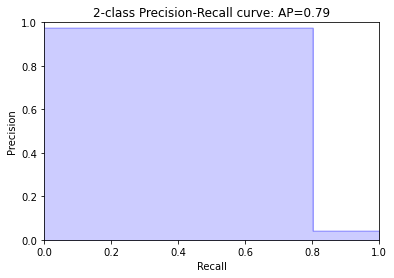

In [61]:
# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

**To Do 3/3**

What's the benefit of the performance metric ROC curve (AUROC) versus Precision and Recall?

**Possible Answers**

* **The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?" but precision and recall don't.**
* ~~The AUROC answers the question: "How meaningful is a positive result from my classifier given the baseline probabilities of my problem?" but precision and recall don't.~~
* ~~Precision and Recall are not informative when the data is imbalanced.~~
* ~~The AUROC curve allows I to visualize classifier performance and with Precision and Recall I cannot.~~

**The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.**

## Adjusting the algorithm weights

* Adjust model parameter to optimize for fraud detection.
* When training a model, try different options and settings to get the best recall-precision trade-off
* sklearn has two simple options to tweak the model for heavily imbalanced data
    * `class_weight`:
        * `balanced` mode: `model = RandomForestClassifier(class_weight='balanced')`
            * uses the values of y to automatically adjust weights inversely proportional to class frequencies in the the input data
            * this option is available for other classifiers
                * `model = LogisticRegression(class_weight='balanced')`
                * `model = SVC(kernel='linear', class_weight='balanced', probability=True)`
        * `balanced_subsample` mode: `model = RandomForestClassifier(class_weight='balanced_subsample')`
            * is the same as the `balanced` option, except weights are calculated again at each iteration of growing a tree in a the random forest
            * this option is only applicable for the Random Forest model
        * manual input
            * adjust weights to any ratio, not just value counts relative to sample
            * `class_weight={0:1,1:4}`
            * this is a good option to slightly upsample the minority class

#### Hyperparameter tuning

* Random Forest takes many other options to optimize the model

```python
model = RandomForestClassifier(n_estimators=10, 
                               criterion=’gini’, 
                               max_depth=None, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               max_features=’auto’, 
                               n_jobs=-1, class_weight=None)
```

* the shape and size of the trees in a random forest are adjusted with **leaf size** and **tree depth**
* `n_estimators`: one of the most important setting is the number of trees in the forest
* `max_features`: the number of features considered for splitting at each leaf node
* `criterion`: change the way the data is split at each node (default is `gini` coefficient)

#### GridSearchCV for hyperparameter tuning

* [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* `from sklearn.model_selection import GridSearchCV`
* `GridSearchCV evaluates all combinations of parameters defined in the parameter grid
* Random Forest Parameter Grid:

```python
# Create the parameter grid 
param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Define which model to use
model = RandomForestRegressor()

# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, 
                                 param_grid = param_grid, 
                                 cv = 5,
                                 n_jobs = -1, 
                                 scoring='f1')
```

* define the ML model to be used
* put the model into `GridSearchCV`
* pass in `param_grid`
* frequency of cross-validation
* define a scoring metric to evaluate the models
    * the default option is accuracy which isn't optimal for fraud detection
    * use `precision`, `recall` or `f1`

```python
# Fit the grid search to the data
grid_search_model.fit(X_train, y_train)

# Get the optimal parameters 
grid_search_model.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
```

* once `GridSearchCV` and `model` are fit to the data, obtain the parameters belonging to the optimal model by using the `best_params_` attribute
* `GridSearchCV` is computationally heavy
    * Can require many hours, depending on the amount of data and number of parameters in the grid
    * __**Save the Results**__

```python
# Get the best_estimator results
grid_search.best_estimator_
grid_search.best_score_
```

* `best_score_`: mean cross-validated score of the `best_estimator_`, which depends on the `scoring` option

### Model adjustments

A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **`class_weights` option** when defining the `sklearn` model. However, as I will see, it is a bit of a blunt force mechanism and might not work for the very special case.

In this exercise I'll explore the ``weight = "balanced_subsample"`` mode the Random Forest model from the earlier exercise. I already have split the data in a training and test set, i.e `X_train`, `X_test`, `y_train`, `y_test` are available. The metrics function have already been imported.

**To Do**

* Set the `class_weight` argument of the classifier to `balanced_subsample`.
* Fit the model to the training set.
* Obtain predictions and probabilities from X_test.
* Obtain the `roc_auc_score`, the classification report and confusion matrix.

In [62]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5, n_estimators=100)

# Fit the training model to the training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9750299724096771

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2098    1]
 [  18   73]]


**I can see that the model results don't improve drastically. We now have 3 less false positives, but now 19 in stead of 18 false negatives, i.e. cases of fraud we are not catching. If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all, albeit a simple option to try. In the next exercises I'll see how to more smartly tweak the model to focus on reducing false negatives and catch more fraud.**

### Adjusting RF for fraud detection

In this exercise I'm going to dive into the options for the random forest classifier, as we'll **assign weights** and **tweak the shape** of the decision trees in the forest. I'll **define weights manually**, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

The data in this exercise has already been split into training and test set, so I just need to focus on defining the model. I can then use the function `get_model_results()` as a short cut. This function fits the model to the training data, predicts and obtains performance metrics similar to the steps I did in the previous exercises.

**To Do**

* Change the `weight` option to set the ratio to 1 to 12 for the non-fraud and fraud cases, and set the split criterion to 'entropy'.
* Set the maximum depth to 10.
* Set the minimal samples in leaf nodes to 10.
* Set the number of trees to use in the model to 20.

#### def get_model_results

In [63]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit the training model to the training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [64]:
# Change the model options
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9609651901219315

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  14   77]]


**By smartly defining more options in the model, I can obtain better predictions. I have effectively reduced the number of false negatives, i.e. I are catching more cases of fraud, whilst keeping the number of false positives low. In this exercise I've manually changed the options of the model. There is a smarter way of doing it, by using `GridSearchCV`, which I'll see in the next exercise!**

### Parameter optimization with GridSearchCV

In this exercise I'm going to **tweak our model in a less "random" way**, but use `GridSearchCV` to do the work for I.

With `GridSearchCV` I can define **which performance metric to score** the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, I can optimize the model settings to get the best possible Recall score. If I also cared about reducing the number of false positives, I could optimize on F1-score, this gives I that nice Precision-Recall trade-off.

`GridSearchCV` has already been imported from `sklearn.model_selection`, so let's give it a try!

**To Do**

* Define in the parameter grid that I want to try 1 and 30 trees, and that I want to try the `gini` and `entropy` split criterion.
* Define the model to be simple `RandomForestClassifier`, I want to keep the random_state at 5 to be able to compare models.
* Set the `scoring` option such that it optimizes for recall.
* Fit the model to the training data `X_train` and `y_train` and obtain the best parameters for the model.

In [65]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

### Model results with GridSearchCV

I discovered that the **best parameters for the model** are that the split criterion should be set to `'gini'`, the number of estimators (trees) should be 30, the maximum depth of the model should be 8 and the maximum features should be set to `"log2"`.

Let's give this a try and see how well our model performs. I can use the `get_model_results()` function again to save time.

**To Do**

* Input the optimal settings into the model definition.
* Fit the model, obtain predictions and get the performance parameters with `get_model_results()`.

In [66]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Get results from the model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


**The model has been improved even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, I see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, I need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by I and the fraud team together.**

## Ensemble methods

![ensemble](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/ensemble.JPG)
* Ensemble methods are techniques that create multiple machine learning models and then combine them to produce a final result
* Usually produce more accurate predictions than a single model
* The goal of an ML problem is to find a single model that will best predict our wanted outcome
    * Use ensemble methods rather than making one model and hoping it's best, most accurate predictor
* Ensemble methods take a myriad of models into account and average them to produce one final model
    * Ensures the predictions are robust
    * Less likely to be the result of overfitting
    * Can improve prediction performance
        * Especially by combining models with different recall and precision scores
    * Are a winning formula at Kaggle competitions
* The Random Forest classifier is an ensemble of Decision Trees
    * **Bootstrap Aggregation** or **Bagging Ensemble** method
    * In a Random Forest, models are trained on random subsamples of data and the results are aggregated by taking the average prediction of all the trees

#### Stacking Ensemble Methods

![stacking ensemble](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/ensemble_stacking.JPG)
* Multiple models are combined via a "voting" rule on the model outcome
* The base level models are each trained based on the complete training set
    * Unlike the Bagging method, models are not trained on a subsample of the data
* Algorithms of different types can be combined

#### Voting Classifier

* available in sklearn
    * easy way of implementing an ensemble model

```python
from sklearn.ensemble import VotingClassifier

# Define Models
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

# Combine models into ensemble
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

# Fit and predict as with other models
ensemble_model.fit(X_train, y_train)
ensemble_model.predict(X_test)
```

* the `voting='hard'` option uses the predicted class labels and takes the majority vote
* the `voting='soft'` option takes the average probability by combining the predicted probabilities of the individual models
* Weights can be assigned to the `VotingClassifer` with `weights=[2,1,1]`
    * Useful when one model significantly outperforms the others

#### Reliable Labels

* In real life it's unlikely the data will have truly unbiased, reliable labels for the model
* In credit card fraud I often will have reliable labels, in which case, use the methods learned so far
* Most cases I'll need to rely on unsupervised learning techniques to detect fraud

### Logistic Regression

In this last lesson I'll **combine three algorithms** into one model with the **VotingClassifier**. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. I'll also add a Decision Tree with balanced weights to it. The data is already split into a training and test set, i.e. `X_train`, `y_train`, `X_test`, `y_test` are available.

In order to understand how the Voting Classifier can potentially improve the original model, I should check the standalone results of the Logistic Regression model first.

**To Do**

* Define a LogisticRegression model with class weights that are 1:15 for the fraud cases.
* Fit the model to the training set, and obtain the model predictions.
* Print the classification report and confusion matrix.

In [67]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver='liblinear')

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9722054981702433

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2052   47]
 [  11   80]]


**As I can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.**

### Voting Classifier

Let's now **combine three machine learning models into one**, to improve our Random Forest fraud detection model from before. I'll combine our usual Random Forest model, with the Logistic Regression from the previous exercise, with a simple Decision Tree. I can use the short cut `get_model_results()` to see the immediate result of the ensemble model.

**To Do**

* Import the Voting Classifier package.
* Define the three models; use the Logistic Regression from before, the Random Forest from previous exercises and a Decision tree with balanced class weights.
* Define the ensemble model by inputting the three classifiers with their respective labels.

In [68]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2090    9]
 [  13   78]]


**By combining the classifiers, I can take the best of multiple models. I've increased the cases of fraud I are catching from 76 to 78, and I only have 5 extra false positives in return. If I do care about catching as many fraud cases as I can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together I indeed managed to improve performance.**

### Adjusting weights within the Voting Classifier

I've just seen that the Voting Classifier allows I to improve the fraud detection performance, by combining good aspects from multiple models. Now let's try to **adjust the weights** we give to these models. By increasing or decreasing weights I can play with **how much emphasis I give to a particular model** relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but I still want to combine aspects of the others to further improve the results.

For this exercise the data is already split into a training and test set, and `clf1`, `clf2` and `clf3` are available and defined as before, i.e. they are the Logistic Regression, the Random Forest model and the Decision Tree respectively.

**To Do**

* Define an ensemble method where I over weigh the second classifier (`clf2`) with 4 to 1 to the rest of the classifiers.
* Fit the model to the training and test set, and obtain the predictions `predicted` from the ensemble model.
* Print the performance metrics, this is ready for I to run.

In [69]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9739226947421326

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  14   77]]


**The weight option allows I to play with the individual models to get the best final mix for the fraud detection model. Now that I have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when I don't have any labels to train on.**

# Fraud detection using unlabeled data

Use unsupervised learning techniques to detect fraud. Segment customers, use K-means clustering and other clustering algorithms to find suspicious occurrences in the data.

## Normal versus abnormal behavior

* Explore fraud detection without reliable data labels
* Unsupervised learning to detect suspicious behavior
* Abnormal behavior isn't necessarily fraudulent
* Challenging because it's difficult to validate

#### What's normal behavior?

* thoroughly describe the data:
    * plot histograms
    * check for outliers
    * investigate correlations
* Are there any known historic cases of fraud? What typifies those cases?
* Investigate whether the data is homogeneous, or whether different types of clients display different behavior
* Check patterns within subgroups of data: is the data homogeneous?
* Verify data points are the same type:
    * individuals
    * groups
    * companies
    * governmental organizations
* Do the data points differ on:
    * spending patterns
    * age
    * location
    * frequency
* For credit card fraud, location can be an indication of fraud
* This goes for e-commerce sites
    * where's the IP address located and where is the product ordered to ship?
* Create a separate model for each segment
* How to aggregate the many model results back into one final list

### Exploring the data

In the next exercises, I will be looking at bank **payment transaction data**. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, I have some client characteristics available such as age group and gender. Some of the transactions are labeled as fraud; I'll treat these labels as given and will use those to validate the results.

When using unsupervised learning techniques for fraud detection, I want to **distinguish normal from abnormal** (thus potentially fraudulent) behavior. As a fraud analyst to understand what is "normal", I need to have a good understanding of the data and its characteristics. Let's explore the data in this first exercise.

**To Do 1/3**

* Obtain the shape of the dataframe `df` to inspect the size of our data and display the first rows to see which features are available.

In [70]:
banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [71]:
banksim_df.shape

(7200, 5)

In [72]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [73]:
banksim_adj_df.shape

(7189, 18)

In [74]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**To Do 2/3**

* Group the data by transaction category and take the mean of the data.

In [75]:
banksim_df.groupby(['category']).mean()

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


**To Do 3/3**

Based on these results, can I already say something about fraud in our data?

**Possible Answers**

* ~~No, I don't have enough information.~~
* **Yes, the majority of fraud is observed in travel, leisure and sports related transactions.**

### Customer segmentation

In this exercise I'm going to check whether there are any **obvious patterns** for the clients in this data, thus whether I need to segment the data into groups, or whether the data is rather homogenous.

I unfortunately don't have a lot client information available; I can't for example distinguish between the wealth levels of different clients. However, there is data on **age ** available, so let's see whether there is any significant difference between behavior of age groups.

**To Do 1/3**

* Group the dataframe `df` by the category `age` and get the means for each age group.

In [76]:
banksim_df.groupby(['age']).mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


**To Do 2/3**

* Count the values of each age group.

In [77]:
banksim_df.age.value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

**To Do 3/3**

Based on the results I see, does it make sense to divide the data into age segments before running a fraud detection algorithm?

**Possible Answers**

* **No, the age groups who are the largest are relatively similar.**
* ~~Yes, the age group "0" is very different and I would split that one out.~~

**The average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.**

### Using statistics to define normal behavior

In the previous exercises we saw that fraud is **more prevalent in certain transaction categories**, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the **average amounts spent** in normal transactions versus fraud transactions. This gives I an idea of how fraudulent transactions **differ structurally** from normal transactions.

**To Do**

* Create two new dataframes from fraud and non-fraud observations. Locate the data in `df` with `.loc` and assign the condition "where fraud is 1" and "where fraud is 0" for creation of the new dataframes.
* Plot the `amount` column of the newly created dataframes in the histogram plot functions and assign the labels `fraud` and `nonfraud` respectively to the plots.

In [78]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

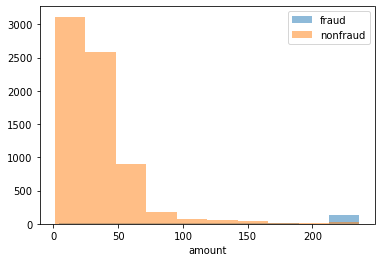

In [79]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

**As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, I can see that the fraudulent transactions tend to be on the larger side relative to normal observations. This is good news, as it helps us later in detecting fraud from non-fraud. In the next chapter I'm going to implement a clustering model to distinguish between normal and abnormal transactions, when the fraud labels are no longer available.**

## Clustering methods to detect fraud

#### K-means clustering

![k-means](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/k-means.JPG)

* The objective of any clustering model is to detect patterns in the data
* More specifically, to group the data into distinct clusters made of data points that are very similar to each other, but distinct from the points in the other clusters.
* **The objective of k-means is to minimize the sum of all distances between the data samples and their associated cluster centroids**
    * The score is the inverse of that minimization, so the score should be close to 0.
* **Using the distance to cluster centroids**
    * Training samples are shown as dots and cluster centroids are shown as crosses
    * Attempt to cluster the data in image A
        * Start by putting in an initial guess for two cluster centroids, as in B
        * Predefine the number of clusters at the start
        * Then calculate the distances of each sample in the data to the closest centroid
        * Figure C shows the data split into the two clusters
        * Based on the initial clusters, the location of the centroids can be redefined (fig D) to minimize the sum of all distances in the two clusters.
        * Repeat the step of reassigning points that are nearest to the centroid (fig E) until it converges to the point where no sample gets reassigned to another cluster (fig F)
        * ![clustering](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clustering.JPG)

#### K-means clustering in Python

* It's of utmost importance to scale the data before doing K-means clustering, or any algorithm that uses distances
* Without scaling, features on a larger scale will weight more heavily in the algorithm.  All features should weigh equally at the initial stage
* fix `random_state` so models can be compared

```python
# Import the packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transform and scale the data
X = np.array(df).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the k-means model and fit to the data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)
```

#### The right amount of clusters

* The drawback of K-means clustering is the need to assign the number of clusters beforehand
* There are multiple ways to check what the right number of clusters should be
    * Silhouette method
    * Elbow curve
* By running a k-means model on clusters varying from 1 to 10 and generate an **elbow curve** by saving the scores for each model under "score".
* Plot the scores against the number of clusters

    
```python
clust = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in clust]

score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
```

![elbow curve](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/elbow.JPG)

* The slight elbow at 3 means that 3 clusters could be optimal, but it's not very pronounced

### Scaling the data

For ML algorithms using distance based metrics, it is **crucial to always scale the data**, as features using different scales will distort the results. K-means uses the Euclidean distance to assess distance to cluster centroids, therefore I first need to scale the data before continuing to implement the algorithm. Let's do that first.

Available is the dataframe `df` from the previous exercise, with some minor data preparation done so it is ready for I to use with `sklearn`. The fraud labels are separately stored under labels, I can use those to check the results later.

**To Do**

* Import the ``MinMaxScaler``.
* Transform the dataframe `df` into a numpy array `X` by taking only the values of `df` and make sure I have all `float` values.
* Apply the defined scaler onto `X` to obtain scaled values of `X_scaled` to force all the features to a 0-1 scale.

In [80]:
labels = banksim_adj_df.fraud

In [81]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [82]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)

In [83]:
X.shape

(7189, 17)

In [84]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### K-mean clustering

A very commonly used clustering algorithm is **K-means clustering**. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when I are working with transaction data. **MiniBatch K-means** is an **efficient way** to implement K-means on a large dataset, which I will use in this exercise.

The scaled data from the previous exercise, `X_scaled` is available. Let's give it a try.

**To Do**

* Import `MiniBatchKMeans` from `sklearn`.
* Initialize the minibatch kmeans model with 8 clusters.
* Fit the model to the scaled data.

In [85]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

**I have now fitted the MiniBatch K-means model to the data. In the upcoming exercises I'm going to explore whether this model is any good at flagging fraud. But before doing that, I still need to figure our what the right number of clusters to use is. Let's do that in the next exercise.**

### Elbow method

In the previous exercise I've implemented MiniBatch K-means with 8 clusters, without actually checking what the right amount of clusters should be. For our first fraud detection approach, it is important to **get the number of clusters right**, especially when I want to use the outliers of those clusters as fraud predictions. To decide which amount of clusters I'm going to use, let's apply the **Elbow method** and see what the optimal number of clusters should be based on this method.

`X_scaled` is again available for I to use and `MiniBatchKMeans` has been imported from `sklearn`.

**To Do**

* Define the range to be between 1 and 10 clusters.
* Run MiniBatch K-means on all the clusters in the range using list comprehension.
* Fit each model on the scaled data and obtain the scores from the scaled data.
* Plot the cluster numbers and their respective scores.

In [86]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

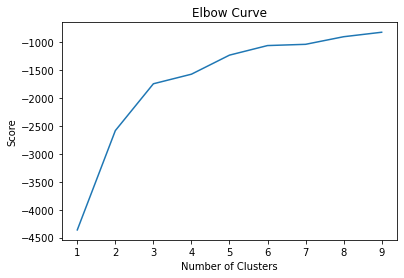

In [87]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Now I can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud**

## Assigning fraud vs. non-fraud

* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_1.JPG)
* Take the outliers of each cluster, and flag those as fraud.
* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_2.JPG)
1. Collect and store the cluster centroids in memory
    * Starting point to decide what's normal and not
1. Calculate the distance of each point in the dataset, to their own cluster centroid
* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_3.JPG)
    * Euclidean distance is depicted by the circles in this case
    * Define a cut-off point for the distances to define what's an outlier
        * Done based on the distributions of the distances collected
        * i.e. everything with a distance larger than the top 95th percentile, should be considered an outlier
        * the tail of the distribution of distances
        * anything outside the yellow circles is an outlier
        * ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_4.JPG)
        * these are definitely outliers and can be described as abnormal or suspicious
            * doesn't necessarily mean they are fraudulent

#### Flagging Fraud Based on Distance to Centroid

```python
# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0
```

* `np.linalg.norm`: returns the vector norm, the vector of distance for each datapoint to their assigned cluster
* use the percentiles of the distances to determine which samples are outliers

#### Validating the Model Results

* without fraud labels, the usual performance metrics can't be run
    * check with the fraud analyst
    * investigate and describe cases that are flagged in more detail
        * is it fraudulent or just a rare case of legit data
        * avoid rare, legit cases by deleting certain features or removing the cases from the data
    * if there are past cases of fraud, see if the model can predict them using historic data

### Detecting outliers

In the next exercises, I'm going to use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that are saved, to sense check our results.

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. I'll learn how to do this and how to determine the cut-off in this exercise. In the next one, I'll check the results.

Available are the scaled observations X_scaled, as well as the labels stored under the variable y.

**To Do**

* Split the scaled data and labels y into a train and test set.
* Define the MiniBatch K-means model with 3 clusters, and fit to the training data.
* Get the cluster predictions from the test data and obtain the cluster centroids.
* Define the boundary between fraud and non fraud to be at 95% of distance distribution and higher.

In [88]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

### Checking model results

In the previous exercise I've flagged all observations to be fraud, if they are in the top 5th percentile in distance from the cluster centroid. I.e. these are the very outliers of the three clusters. For this exercise I have the scaled data and labels already split into training and test set, so y_test is available. The predictions from the previous exercise, km_y_pred, are also available. Let's create some performance metrics and see how well I did.

**To Do 1/3**

* Obtain the area under the ROC curve from the test labels and predicted labels.

In [89]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_laIt()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [90]:
# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

0.8197704982668266

**To Do 2/3**

* Obtain the confusion matrix from the test labels and predicted labels and plot the results.

Confusion matrix, without normalization


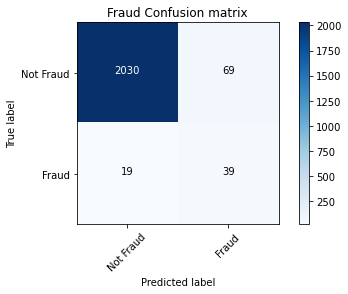

In [91]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

**To Do 3/3**

If I were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to the prediction results?

**Possible Answers**

* **The number of fraud cases caught increases, but false positives also increase.**
* ~~The number of fraud cases caught decreases, and false positives decrease.~~
* ~~The number of fraud cases caught increases, but false positives would decrease.~~
* ~~Nothing would happen to the amount of fraud cases caught.~~

## Alternate clustering methods for fraud detection

* In addition to K-means, there are many different clustering methods, which can be used for fraud detection
* ![clustering methods](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clustering_methods.JPG)
* K-means works well when the data is clustered in normal, round shapes
* There are methods to flag fraud other the cluster outliers
* ![clustering outlier](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/cluster_outlier.JPG)
    * Small clusters can be an indication of fraud
    * This approach can be used when fraudulent behavior has commonalities, which cause clustering
    * The fraudulent data would cluster in tiny groups, rather than be the outliers of larger clusters
* ![typical data](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/typical_data.JPG)
    * In this case there are 3 obvious clusters
    * The smallest dots are outliers and outside of what can be described as normal behavior
    * There are also small to medium clusters closely connected to the red cluster
    * Visualizing the data with something like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) can be quite helpful

#### DBSCAN: Density-Based Spatial Clustering of Applications with Noise

* [DBscan](https://en.wikipedia.org/wiki/DBSCAN)
* DBSCAN vs. K-means
    * The number of clusters does not need to be predefined
        * The algorithm finds core samples of high density and expands clusters from them
        * Works well on data containing clusters of similar density
    * This type of algorithm can be used to identify fraud as very small clusters
    * Maximum allowed distance between points in a cluster must be assigned
    * Minimal number of data points in clusters must be assigned
    * Better performance on weirdly shaped data
    * Computationally heavier then MiniBatch K-means

#### Implementation of DBSCAN

```python
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled)

# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

# Print model results
print(f'Estimated number of clusters: {n_clusters_}')
>>> Estimated number of clusters: 31
    
# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')
>>> Silhouette Coefficient: 0.359
    
# Get sample counts in each cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)
>>> [ 763, 496, 840, 355 1086, 676, 63, 306, 560, 134, 28, 18, 262, 128,
     332, 22, 22, 13, 31, 38, 36, 28, 14, 12, 30, 10, 11, 10, 21, 10, 5]
```

* start by defining the epsilon `eps`
    * Distance between data points allowed from which the cluster expands
* define minimum samples in the clusters
* conventional DBSCAN can't produce the optimal value of epsilon, so it requires sophisticated DBSCAN modifications to automatically determine the optimal epsilon value
* Fit DBSCAN to **scaled data**
* Use `labels_` method to get the assigned cluster label for each data point
* The cluster count can also be determine by counting the unique cluster labels from the cluster `label_` predictions
* Can have performance metrics such as **average silhouette score**
* The size of each cluster can be calculated with `np.bincount`
    * counts the number of occurrences of non-negative values in a `numpy` array
* sort `counts` and decide how many of the smaller clusters to flag as fraud
    * selecting the clusters to flag, is a trial-and-error step and depends on the number of cases the fraud team can manage

### DB scan

In this exercise I'm going to explore using a **density based clustering** method (DBSCAN) to detect fraud. The advantage of DBSCAN is that I **do not need to define the number of clusters** beforehand. Also, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can. This time, I are not going to take the outliers of the clusters and use that for fraud, but take the **smallest clusters** in the data and label those as fraud. I again have the scaled dataset, i.e. X_scaled available. Let's give it a try!

**To Do**

* Import `DBSCAN`.
* Initialize a DBSCAN model setting the maximum distance between two samples to 0.9 and the minimum observations in the clusters to 10, and fit the model to the scaled data.
* Obtain the predicted labels, these are the cluster numbers assigned to an observation.
* Print the number of clusters and the rest of the performance metrics.

In [92]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [93]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


**The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. Now have a look at those clusters and decide which one to flag as fraud.**

### Assessing smallest clusters

In this exercise I'm going to have a look at the clusters that came out of DBscan, and flag certain clusters as fraud:

* I first need to figure out how big the clusters are, and **filter out the smallest**
* then, I'm going to take the smallest ones and **flag those as fraud**
* last, I'll **check with the original labels** whether this does actually do a good job in detecting fraud.

Available are the DBscan model predictions, so `n_clusters` is available as well as the cluster labels, which are saved under `pred_labels`. Let's give it a try!

**To Do 1/3**

* Count the samples within each cluster by running a bincount on the predicted cluster numbers under `pred_labels` and print the results.

In [94]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


**To Do 2/3**

* Sort the sample `counts` and take the top 3 smallest clusters, and print the results.

In [95]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [96]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


**To Do 3/3**

* Within `counts`, select the smallest clusters only, to print the number of samples in the three smallest clusters.

In [97]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


**So now we know which smallest clusters I could flag as fraud. If I were to take more of the smallest clusters, I cast the net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate. In the next exercise I'll check the results with the actual labels.**

### Results verification

In this exercise I'm going to **check the results** of the DBscan fraud detection model. In reality, I often don't have reliable labels and this where a fraud analyst can help I validate the results. He/She can check the results and see whether the cases I flagged are indeed suspicious. I can also **check historically known cases** of fraud and see whether the model flags them.

In this case, I'll **use the fraud labels** to check the model results. The predicted cluster numbers are available under `pred_labels` as well as the original fraud `labels`.

**To Do**

* Create a dataframe combining the cluster numbers with the actual labels.
* Create a condition that flags fraud for the three smallest clusters: clusters 21, 17 and 9.
* Create a crosstab from the actual fraud labels with the newly created predicted fraud labels.

In [98]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

In [99]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


**How does this compare to the K-means model? The good thing is: our of all flagged cases, roughly 2/3 are actually fraud! Since I only take the three smallest clusters, by definition I flag less cases of fraud, so I catch less but also have less false positives. However, I are missing quite a lot of fraud cases. Increasing the amount of smallest clusters I flag could improve that, at the cost of more false positives of course.**